# Imports

In [1]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy.linalg import norm

# Deep learning:
# from tensorflow.python.keras.models import Input

from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from keras.models import Model

# from keras.models import Input, Model

from scipy import sparse
from pathlib import Path

# Loading Data

In [3]:
text1 = Path('Breaking_Bad.txt').read_text()

In [5]:
text2 = Path('Peaky_Blinders.txt').read_text()

# Preproccessing

In [6]:
text1 = text1.replace(',','.').replace(':','.').replace('/','.').replace('!','.').replace('?','.').split('.')
text2 = text2.replace(',','.').replace(':','.').replace('/','.').replace('!','.').replace('?','.').split('.')

In [8]:
def text_preprocessing(
        text: list,
        punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
        stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will', 'was', 'but', 'this', 'were', 'with', 'of', 'also',
                    'on', '.', 'for', 'any', 'its', 'and', 'are', 'from', 'both', 'as','to','my','your','his','her','mine','yours','hers']
) -> list:
    """
    A method to preproces text
    """
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x != '']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

In [9]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists1 = []
all_text1 = []
for text in text1:

    # Cleaning the text
    text = text_preprocessing(text)
    
    # Appending to the all text list
    all_text1 += text

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text):
                word_lists1.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words
            if i - w - 1 >= 0:
                word_lists1.append([word] + [text[(i - w - 1)]])

word_lists1

[['breaking', 'bad'],
 ['breaking', 'an'],
 ['bad', 'an'],
 ['bad', 'breaking'],
 ['bad', 'american'],
 ['an', 'american'],
 ['an', 'bad'],
 ['an', 'crime'],
 ['an', 'breaking'],
 ['american', 'crime'],
 ['american', 'an'],
 ['american', 'drama'],
 ['american', 'bad'],
 ['crime', 'drama'],
 ['crime', 'american'],
 ['crime', 'television'],
 ['crime', 'an'],
 ['drama', 'television'],
 ['drama', 'crime'],
 ['drama', 'series'],
 ['drama', 'american'],
 ['television', 'series'],
 ['television', 'drama'],
 ['television', 'created'],
 ['television', 'crime'],
 ['series', 'created'],
 ['series', 'television'],
 ['series', 'produced'],
 ['series', 'drama'],
 ['created', 'produced'],
 ['created', 'series'],
 ['created', 'by'],
 ['created', 'television'],
 ['produced', 'by'],
 ['produced', 'created'],
 ['produced', 'vince'],
 ['produced', 'series'],
 ['by', 'vince'],
 ['by', 'produced'],
 ['by', 'gilligan'],
 ['by', 'created'],
 ['vince', 'gilligan'],
 ['vince', 'by'],
 ['vince', 'produced'],
 ['

In [10]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists2 = []
all_text2 = []
for text in text2:

    # Cleaning the text
    text = text_preprocessing(text)
    # print (text)

    # Appending to the all text list
    all_text2 += text

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text):
                word_lists2.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words
            if i - w - 1 >= 0:
                word_lists2.append([word] + [text[(i - w - 1)]])

word_lists2

[['peaky', 'blinders'],
 ['peaky', 'british'],
 ['blinders', 'british'],
 ['blinders', 'peaky'],
 ['blinders', 'period'],
 ['british', 'period'],
 ['british', 'blinders'],
 ['british', 'crime'],
 ['british', 'peaky'],
 ['period', 'crime'],
 ['period', 'british'],
 ['period', 'drama'],
 ['period', 'blinders'],
 ['crime', 'drama'],
 ['crime', 'period'],
 ['crime', 'television'],
 ['crime', 'british'],
 ['drama', 'television'],
 ['drama', 'crime'],
 ['drama', 'series'],
 ['drama', 'period'],
 ['television', 'series'],
 ['television', 'drama'],
 ['television', 'created'],
 ['television', 'crime'],
 ['series', 'created'],
 ['series', 'television'],
 ['series', 'by'],
 ['series', 'drama'],
 ['created', 'by'],
 ['created', 'series'],
 ['created', 'steven'],
 ['created', 'television'],
 ['by', 'steven'],
 ['by', 'created'],
 ['by', 'knight'],
 ['by', 'series'],
 ['steven', 'knight'],
 ['steven', 'by'],
 ['steven', 'created'],
 ['knight', 'steven'],
 ['knight', 'by'],
 ['set', 'birmingham'],
 [

# Creating Unique Word Dictionary

In [11]:
def create_unique_word_dict(text: list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict

In [12]:
unique_word_dict1 = create_unique_word_dict(all_text1)
# Defining the number of features (unique words)
n_words = len(unique_word_dict1)
print(unique_word_dict1)

# Getting all the unique words
words1 = list(unique_word_dict1.keys())
print(words1)

# Creating the X and Y matrices using one hot encoding
print(n_words)
X1 = []
Y1 = []
for i, word_list in tqdm(enumerate(word_lists1)):
    # Getting the indices
    print(word_list)
    main_word_index = unique_word_dict1.get(word_list[0])
    context_word_index = unique_word_dict1.get(word_list[1])
    # print (word_list)
    print(word_list[0], main_word_index)
    print(word_list[1], context_word_index)

    # Creating the placeholders
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X1.append(X_row)
    Y1.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
print(X1)
print(Y1)

{'aaron': 0, 'acclaim': 1, 'acclaimed': 2, 'actor': 3, 'actress': 4, 'agent': 5, 'aired': 6, 'albuquerque': 7, 'all': 8, 'alquist': 9, 'ambitious': 10, 'amc': 11, 'american': 12, 'among': 13, 'an': 14, 'anna': 15, 'appearances': 16, 'association': 17, 'august': 18, 'available': 19, 'award': 20, 'awards': 21, 'bad': 22, 'bads': 23, 'banks': 24, 'been': 25, 'before': 26, 'betsy': 27, 'better': 28, 'bob': 29, 'brandt': 30, 'breaking': 31, 'bryan': 32, 'business': 33, 'by': 34, 'cable': 35, 'call': 36, 'camino': 37, 'cancer': 38, 'character': 39, 'chemistry': 40, 'choice': 41, 'cinematography': 42, 'company': 43, 'concluded': 44, 'conclusion': 45, 'consisting': 46, 'costars': 47, 'cranston': 48, 'created': 49, 'crime': 50, 'criminal': 51, 'criminally': 52, 'critical': 53, 'critically': 54, 'critics': 55, 'cunning': 56, 'dangers': 57, 'dea': 58, 'dean': 59, 'debuted': 60, 'development': 61, 'diagnosis': 62, 'dies': 63, 'direction': 64, 'dispirited': 65, 'distribute': 66, 'drama': 67, 'drast

216it [00:00, 2138.60it/s]

['breaking', 'bad']
breaking 31
bad 22
['breaking', 'an']
breaking 31
an 14
['bad', 'an']
bad 22
an 14
['bad', 'breaking']
bad 22
breaking 31
['bad', 'american']
bad 22
american 12
['an', 'american']
an 14
american 12
['an', 'bad']
an 14
bad 22
['an', 'crime']
an 14
crime 50
['an', 'breaking']
an 14
breaking 31
['american', 'crime']
american 12
crime 50
['american', 'an']
american 12
an 14
['american', 'drama']
american 12
drama 67
['american', 'bad']
american 12
bad 22
['crime', 'drama']
crime 50
drama 67
['crime', 'american']
crime 50
american 12
['crime', 'television']
crime 50
television 221
['crime', 'an']
crime 50
an 14
['drama', 'television']
drama 67
television 221
['drama', 'crime']
drama 67
crime 50
['drama', 'series']
drama 67
series 205
['drama', 'american']
drama 67
american 12
['television', 'series']
television 221
series 205
['television', 'drama']
television 221
drama 67
['television', 'created']
television 221
created 49
['television', 'crime']
television 221
crime 50

652it [00:00, 2056.85it/s]

['fraser', 'laura']
fraser 96
laura 134
['fraser', 'rodartequayle']
fraser 96
rodartequayle 189
['lydia', 'rodartequayle']
lydia 139
rodartequayle 189
['lydia', 'fraser']
lydia 139
fraser 96
['lydia', 'laura']
lydia 139
laura 134
['rodartequayle', 'lydia']
rodartequayle 189
lydia 139
['rodartequayle', 'fraser']
rodartequayle 189
fraser 96
['cunning', 'business']
cunning 56
business 33
['cunning', 'executive']
cunning 56
executive 77
['business', 'executive']
business 33
executive 77
['business', 'cunning']
business 33
cunning 56
['business', 'secretly']
business 33
secretly 201
['executive', 'secretly']
executive 77
secretly 201
['executive', 'business']
executive 77
business 33
['executive', 'managing']
executive 77
managing 141
['executive', 'cunning']
executive 77
cunning 56
['secretly', 'managing']
secretly 201
managing 141
['secretly', 'executive']
secretly 201
executive 77
['secretly', 'walters']
secretly 201
walters 241
['secretly', 'business']
secretly 201
business 33
['managin

1058it [00:00, 2132.67it/s]


['lead', 'drama']
lead 136
drama 67
['lead', 'award']
lead 136
award 20
['actor', 'drama']
actor 3
drama 67
['actor', 'lead']
actor 3
lead 136
['actor', 'series']
actor 3
series 205
['actor', 'outstanding']
actor 3
outstanding 163
['drama', 'series']
drama 67
series 205
['drama', 'actor']
drama 67
actor 3
['drama', 'four']
drama 67
four 93
['drama', 'lead']
drama 67
lead 136
['series', 'four']
series 205
four 93
['series', 'drama']
series 205
drama 67
['series', 'times']
series 205
times 227
['series', 'actor']
series 205
actor 3
['four', 'times']
four 93
times 227
['four', 'series']
four 93
series 205
['four', 'drama']
four 93
drama 67
['times', 'four']
times 227
four 93
['times', 'series']
times 227
series 205
['while', 'aaron']
while 244
aaron 0
['while', 'paul']
while 244
paul 166
['aaron', 'paul']
aaron 0
paul 166
['aaron', 'while']
aaron 0
while 244
['aaron', 'won']
aaron 0
won 248
['paul', 'won']
paul 166
won 248
['paul', 'aaron']
paul 166
aaron 0
['paul', 'primetime']
paul 166


In [13]:
unique_word_dict2 = create_unique_word_dict(all_text2)
# Defining the number of features (unique words)
n_words = len(unique_word_dict2)
print(unique_word_dict2)

# Getting all the unique words
words2 = list(unique_word_dict2.keys())
print(words2)

# Creating the X and Y matrices using one hot encoding
print(n_words)
X2 = []
Y2 = []
for i, word_list in tqdm(enumerate(word_lists2)):
    # Getting the indices
    print(word_list)
    main_word_index = unique_word_dict2.get(word_list[0])
    context_word_index = unique_word_dict2.get(word_list[1])
    # print (word_list)
    print(word_list[0], main_word_index)
    print(word_list[1], context_word_index)

    # Creating the placeholders
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X2.append(X_row)
    Y2.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
print(X2)
print(Y2)

{'acquired': 0, 'active': 1, 'ada': 2, 'adrien': 3, 'aftermath': 4, 'aidan': 5, 'amber': 6, 'an': 7, 'anderson': 8, 'annabelle': 9, 'announced': 10, 'anya': 11, 'around': 12, 'arthur': 13, 'based': 14, 'bbc': 15, 'birmingham': 16, 'blinders': 17, 'british': 18, 'broadcast': 19, 'brody': 20, 'by': 21, 'cast': 22, 'charlotte': 23, 'cillian': 24, 'city': 25, 'claflin': 26, 'cole': 27, 'company': 28, 'considine': 29, 'created': 30, 'crime': 31, 'deal': 32, 'direct': 33, 'drama': 34, 'elizabeth': 35, 'endemol': 36, 'england': 37, 'ensemble': 38, 'exploits': 39, 'features': 40, 'fictional': 41, 'fifth': 42, 'film': 43, 'final': 44, 'finn': 45, 'first': 46, 'followed': 47, 'follows': 48, 'four': 49, 'fourth': 50, 'frecheville': 51, 'gang': 52, 'gangs': 53, 'gillen': 54, 'goldberg': 55, 'graham': 56, 'gray': 57, 'hardy': 58, 'helen': 59, 'iddo': 60, 'it': 61, 'james': 62, 'january': 63, 'joe': 64, 'john': 65, 'knight': 66, 'last': 67, 'led': 68, 'loosely': 69, 'mccrory': 70, 'members': 71, 'mo

0it [00:00, ?it/s]

['peaky', 'blinders']
peaky 82
blinders 17
['peaky', 'british']
peaky 82
british 18
['blinders', 'british']
blinders 17
british 18
['blinders', 'peaky']
blinders 17
peaky 82
['blinders', 'period']
blinders 17
period 83
['british', 'period']
british 18
period 83
['british', 'blinders']
british 18
blinders 17
['british', 'crime']
british 18
crime 31
['british', 'peaky']
british 18
peaky 82
['period', 'crime']
period 83
crime 31
['period', 'british']
period 83
british 18
['period', 'drama']
period 83
drama 34
['period', 'blinders']
period 83
blinders 17
['crime', 'drama']
crime 31
drama 34
['crime', 'period']
crime 31
period 83
['crime', 'television']
crime 31
television 109
['crime', 'british']
crime 31
british 18
['drama', 'television']
drama 34
television 109
['drama', 'crime']
drama 34
crime 31
['drama', 'series']
drama 34
series 96
['drama', 'period']
drama 34
period 83
['television', 'series']
television 109
series 96
['television', 'drama']
television 109
drama 34
['television', 'c

400it [00:00, 2702.70it/s]


['ada', 'joe']
ada 2
joe 64
['ada', 'sophie']
ada 2
sophie 101
['shelby', 'joe']
shelby 98
joe 64
['shelby', 'ada']
shelby 98
ada 2
['shelby', 'cole']
shelby 98
cole 27
['shelby', 'rundle']
shelby 98
rundle 91
['joe', 'cole']
joe 64
cole 27
['joe', 'shelby']
joe 64
shelby 98
['joe', 'john']
joe 64
john 65
['joe', 'ada']
joe 64
ada 2
['cole', 'john']
cole 27
john 65
['cole', 'joe']
cole 27
joe 64
['cole', 'shelby']
cole 27
shelby 98
['cole', 'shelby']
cole 27
shelby 98
['john', 'shelby']
john 65
shelby 98
['john', 'cole']
john 65
cole 27
['john', 'joe']
john 65
joe 64
['shelby', 'john']
shelby 98
john 65
['shelby', 'cole']
shelby 98
cole 27
['gangs', 'senior']
gangs 53
senior 94
['gangs', 'members']
gangs 53
members 71
['senior', 'members']
senior 94
members 71
['senior', 'gangs']
senior 94
gangs 53
['members', 'senior']
members 71
senior 94
['members', 'gangs']
members 71
gangs 53
['sam', 'neill']
sam 92
neill 76
['neill', 'sam']
neill 76
sam 92
['annabelle', 'wallis']
annabelle 9
wall

In [14]:
import tensorflow as tf

# X= sparse.csr_matrix(X)
# Y = sparse.csr_matrix(Y)
# print (X)
# print(X[0, :].toarray())
# print (X.todense())
# a = X.todense()
# print (a[0])
XX1 = tf.convert_to_tensor(X1, dtype=tf.float32)
YY1 = tf.convert_to_tensor(Y1, dtype=tf.float32)
print(XX1.shape)
print(YY1.shape)

(1058, 250)
(1058, 250)


In [15]:
import tensorflow as tf

# X= sparse.csr_matrix(X)
# Y = sparse.csr_matrix(Y)
# print (X)
# print(X[0, :].toarray())
# print (X.todense())
# a = X.todense()
# print (a[0])
XX2 = tf.convert_to_tensor(X2, dtype=tf.float32)
YY2 = tf.convert_to_tensor(Y2, dtype=tf.float32)
print(XX2.shape)
print(YY2.shape)

(400, 126)
(400, 126)


# Creating Model

In [16]:
def CreateModel(XX,YY):
    # Defining the size of the embedding
    embed_size = 2
    # Defining the neural network

    # inp = Input(shape=(X.shape[1],))
    inp = Input(shape=XX.shape[1])  # 21
    x = Dense(units=embed_size, activation='linear')(inp)
    # x = Dense(units=21, activation='softmax')(x)
    x = Dense(units=YY.shape[1], activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    return model

In [17]:
model1 = CreateModel(XX1,YY1)
# Optimizing the network weights
model1.fit(
    x=XX1,
    y=YY1,
    batch_size=10,
    epochs=2000
)

# The input layer

weights1 = model1.get_weights()[0] #21*2
print(weights1.shape)
print(weights1[1][1])
print(weights1)

# weights = model.get_weights()[2]
# print (weights)

#get the weight for each unique word
embedding_dict1 = {}
for word in words1: #to pick the a row of weight of two values for each unique word since weights = 21*2
    embedding_dict1.update({
        word: weights1[unique_word_dict1.get(word)]
    })

print(embedding_dict1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 dense (Dense)               (None, 2)                 502       
                                                                 
 dense_1 (Dense)             (None, 250)               750       
                                                                 
Total params: 1,252
Trainable params: 1,252
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
106/106 [==============================] - 1s 2ms/step - loss: 5.5175
Epoch 2/2000
106/106 [==============================] - 0s 2ms/step - loss: 5.5011
Epoch 3/2000
106/106 [==============================] - 0s 2ms/step - loss: 5.4883
Epoch 4/2000
106/106 [==============================] - 0s 2ms/step - loss

In [18]:
model2 = CreateModel(XX2,YY2)
# Optimizing the network weights
model2.fit(
    x=XX2,
    y=YY2,
    batch_size=10,
    epochs=2000
)

# The input layer

weights2 = model2.get_weights()[0] #21*2
print(weights2.shape)
print(weights2[1][1])
print(weights2)

# weights = model.get_weights()[2]
# print (weights)

#get the weight for each unique word
embedding_dict2 = {}
for word in words2: #to pick the a row of weight of two values for each unique word since weights = 21*2
    embedding_dict2.update({
        word: weights2[unique_word_dict2.get(word)]
    })

print(embedding_dict2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 126)]             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 254       
                                                                 
 dense_3 (Dense)             (None, 126)               378       
                                                                 
Total params: 632
Trainable params: 632
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
40/40 [==============================] - 0s 2ms/step - loss: 4.8362
Epoch 2/2000
40/40 [==============================] - 0s 2ms/step - loss: 4.8268
Epoch 3/2000
40/40 [==============================] - 0s 2ms/step - loss: 4.8199
Epoch 4/2000
40/40 [==============================] - 0s 2ms/step - loss: 4.8130
E

In [ ]:
def centroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [19]:
center1 = centroidnp(weights1)
center1

[1.3688490731278435, 1.90688645685371]

In [20]:
center2 = centroidnp(weights2)
center2

[1.5094017189528262, 0.17360453449544452]

In [21]:
cosine = np.dot(center1,center2)/(norm(center1)*norm(center2))
cosine

0.6721543955779765

0  >>  acquired
1  >>  active
2  >>  ada
3  >>  adrien
4  >>  aftermath
5  >>  aidan
6  >>  amber
7  >>  an
8  >>  anderson
9  >>  annabelle
10  >>  announced
11  >>  anya
12  >>  around
13  >>  arthur
14  >>  based
15  >>  bbc
16  >>  birmingham
17  >>  blinders
18  >>  british
19  >>  broadcast
20  >>  brody
21  >>  by
22  >>  cast
23  >>  charlotte
24  >>  cillian
25  >>  city
26  >>  claflin
27  >>  cole
28  >>  company
29  >>  considine
30  >>  created
31  >>  crime
32  >>  deal
33  >>  direct
34  >>  drama
35  >>  elizabeth
36  >>  endemol
37  >>  england
38  >>  ensemble
39  >>  exploits
40  >>  features
41  >>  fictional
42  >>  fifth
43  >>  film
44  >>  final
45  >>  finn
46  >>  first
47  >>  followed
48  >>  follows
49  >>  four
50  >>  fourth
51  >>  frecheville
52  >>  gang
53  >>  gangs
54  >>  gillen
55  >>  goldberg
56  >>  graham
57  >>  gray
58  >>  hardy
59  >>  helen
60  >>  iddo
61  >>  it
62  >>  james
63  >>  january
64  >>  joe
65  >>  john
66  >>  knight
67  >

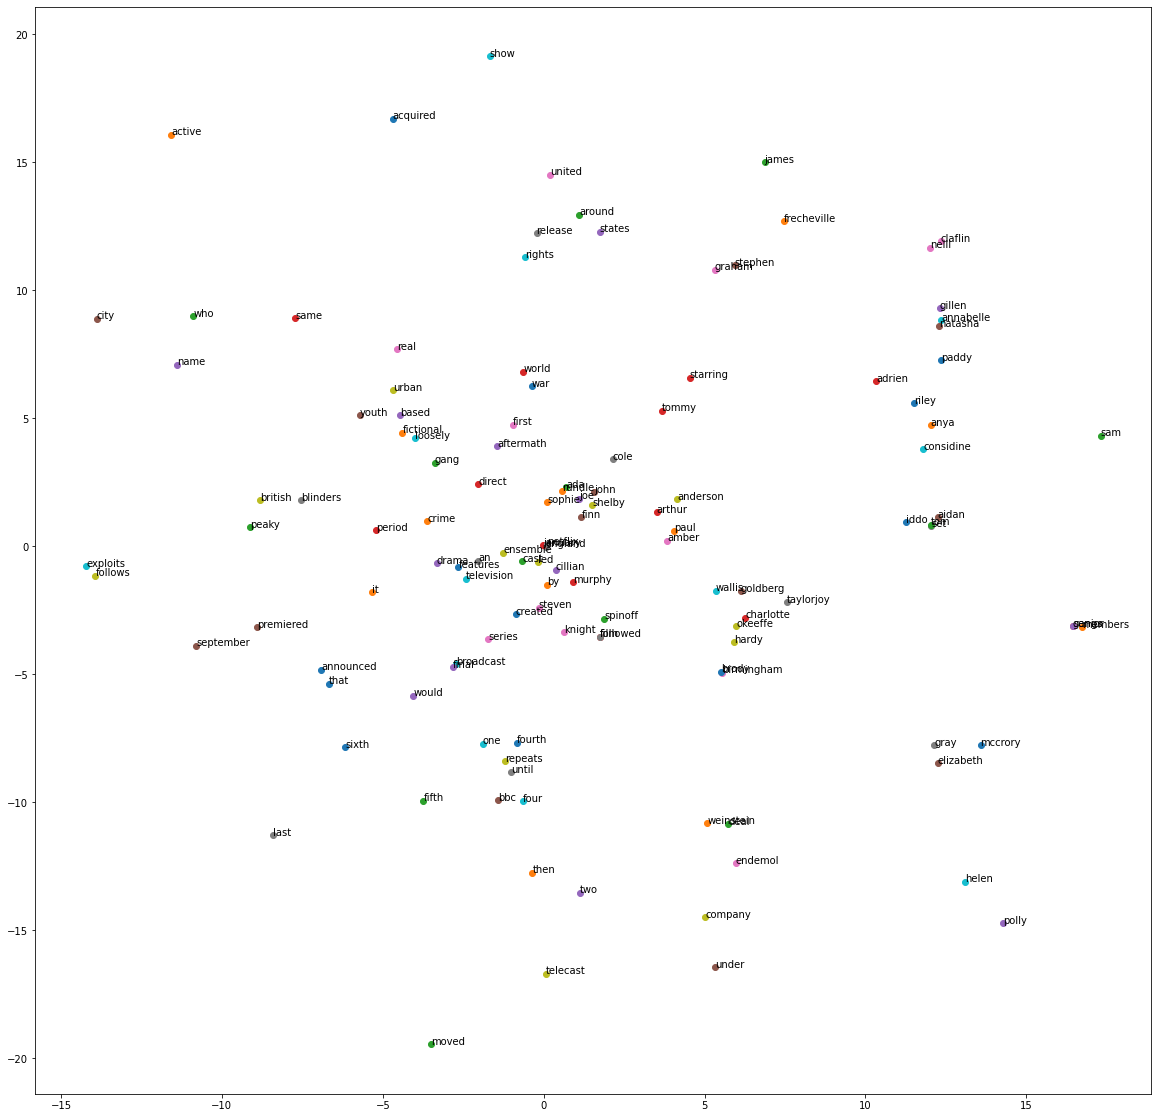

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
i = 0
for word in list(unique_word_dict2.keys()):
    print(i, ' >> ', word)
    coord = embedding_dict2.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))
    i = i + 1

# The input layer
weights = model2.get_weights()[0]
# weights[: , 0] = 0

0  >>  aaron
1  >>  acclaim
2  >>  acclaimed
3  >>  actor
4  >>  actress
5  >>  agent
6  >>  aired
7  >>  albuquerque
8  >>  all
9  >>  alquist
10  >>  ambitious
11  >>  amc
12  >>  american
13  >>  among
14  >>  an
15  >>  anna
16  >>  appearances
17  >>  association
18  >>  august
19  >>  available
20  >>  award
21  >>  awards
22  >>  bad
23  >>  bads
24  >>  banks
25  >>  been
26  >>  before
27  >>  betsy
28  >>  better
29  >>  bob
30  >>  brandt
31  >>  breaking
32  >>  bryan
33  >>  business
34  >>  by
35  >>  cable
36  >>  call
37  >>  camino
38  >>  cancer
39  >>  character
40  >>  chemistry
41  >>  choice
42  >>  cinematography
43  >>  company
44  >>  concluded
45  >>  conclusion
46  >>  consisting
47  >>  costars
48  >>  cranston
49  >>  created
50  >>  crime
51  >>  criminal
52  >>  criminally
53  >>  critical
54  >>  critically
55  >>  critics
56  >>  cunning
57  >>  dangers
58  >>  dea
59  >>  dean
60  >>  debuted
61  >>  development
62  >>  diagnosis
63  >>  dies
64  >>  d

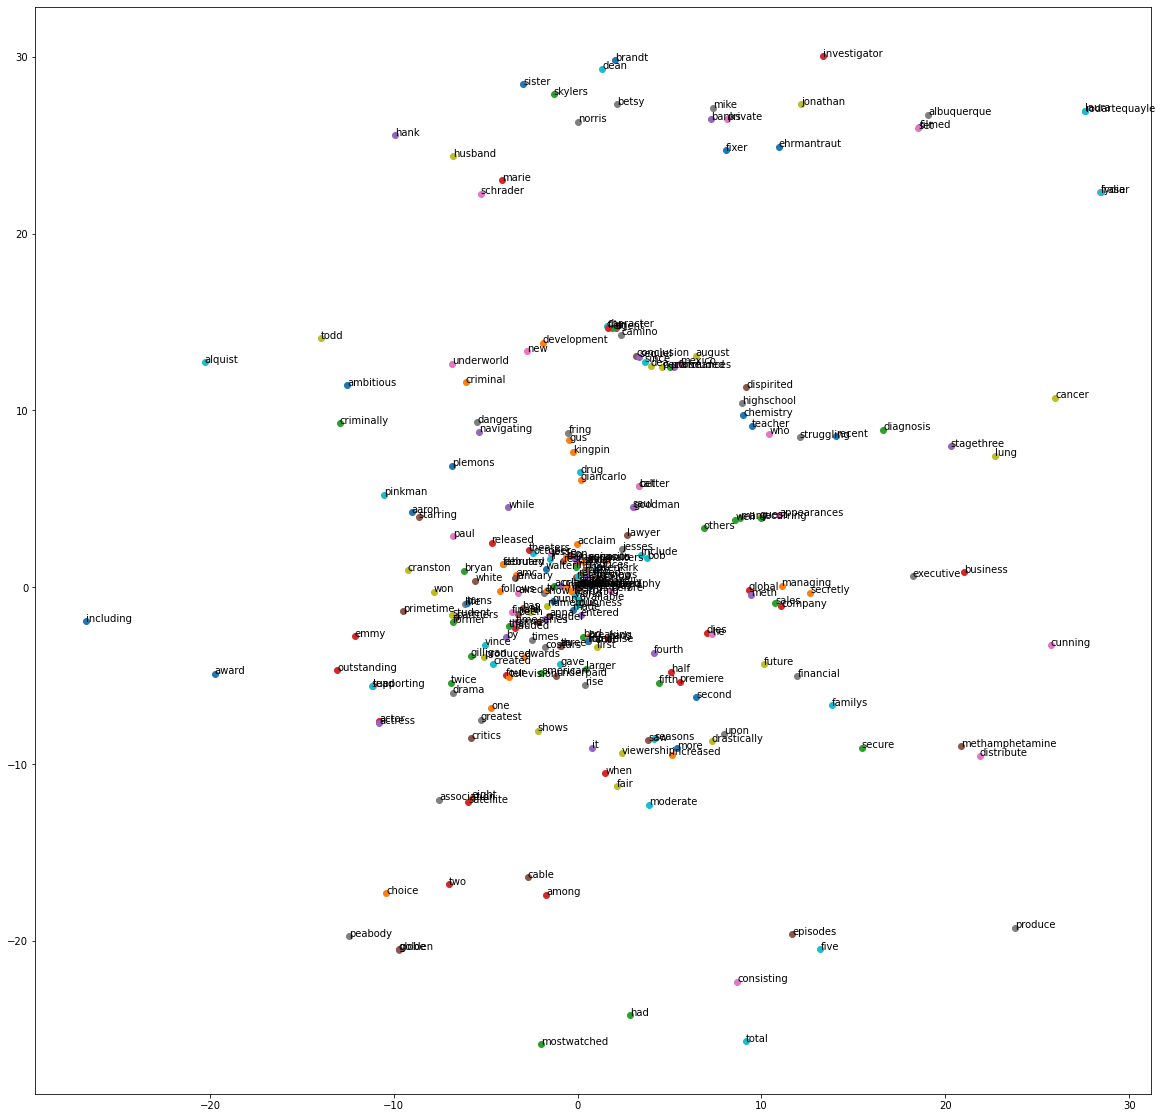

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
i = 0
for word in list(unique_word_dict1.keys()):
    print(i, ' >> ', word)
    coord = embedding_dict1.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))
    i = i + 1

# The input layer
weights = model1.get_weights()[0]
# weights[: , 0] = 0